[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_11_clustering-published.ipynb) (Este botón no anda, tenemos que ver dónde colgaremos las cosas)

    !pip install IPython
    !pip install pandas
    !pip install scipy
    !pip install numpy

In [1]:
from IPython.display import Latex, display
import numpy as np

# Parte 1: Evaluación de modelos.

Este notebook contiene los ejercicios de la primera parte del taller `Evaluación de modelos, series temporales y toma de decisiones` desarrollado para [Escuela Bayes Plurinacional](https://bayesplurinacional.org/) SALTA 2024.

**Ejercicios**:
- 1.1 Modelo Base vs Modelo Monty Hall
    - 1.1.1 Definir sus distribuciones condicionales *a priori*
    - 1.1.2 Simular datos con el modelo Monty Hall
    - 1.1.3 Calcular la secuencia de predicción que hacen los modelo de los datos
    - 1.1.4 Expresar intuitivamente la diferencia de desempeño predictivo de los modelos
    - 1.1.5 Calcular cómo se va actualizando la creencia de los modelos a medida que vamos agregando datos
    - 1.1.6 Graficar el valor del posterior a medida que se observan nuevos episodios
    - 1.1.7 ¿Que ocurriría con la evaluación de modelos si en los datos hubiera al menos una pista sobre la caja cerrada? 
- 1.2 Evaluación de modelos polinomiales de complejidad creciente.
    - 1.2.1. Selección arbitraria de hipótesis por máxima versosimilitud
    - 1.2.2. Evaluación de la predicción "en línea" que hacen los modelos ajustados por máxima verosimilitud
    - 1.2.3. Más criterios arbitrarios de selección de hipótesis: los regularizadores
    - 1.2.4. El balance natural de las reglas de la probabilidad.
    - 1.2.5. ¿Cómo se explica el balance natural de las reglas de la probabilidad?
- 1.3 El efecto causal del sexo biológico sobre la altura. 



## Ejemplo 1.1: Modelo "Base" ($M_0$) vs Modelo "Monty Hall" ($M_1$)
En la siguiente figura se puede observar la especificación gráfica del modelo "Monty Hall" (izquierda) y el modelo "Base" (derecha) visto en la presentación. Abajo de ellos se muestra la distribución de creencias *a posteriori* sobre la posición del regalo luego de que hayamos elegido cerrar la caja $1$ y nos mostraran que la caja $2$ no estaba el regalo, $P(r|s=2,c=1)$

<center>
<img src="https://raw.githubusercontent.com/BayesDeLasProvinciasUnidasDelSur/static/master/curso/2024/MontyHall.png" alt="drawing" width="50%"/>
</center>

El modelo Monty Hall supone que la pista $s$ no puede señalar la caja en la que se encuentra el regalo $s\neq r$ ni la caja que hemos cerrado previamente $s\neq c$. En cambio, el modelo Base supone que la pista $s$ no puede señalar únicamente a la caja en la que se encuentra el regalo $s\neq r$, pudiendo señalar cualquiera de las otras dos cajas, sin tener en cuenta si hemos cerrado una de ellas previamente.

Quisiéramos actualizar nuestras creencias sobre los modelos causales alternativos luego de observar los datos, $P(\text{Modelo}|\text{Datos})$.

$$P(\text{Modelo}|\text{Datos}) = \frac{P(\text{Datos}|\text{Modelo})P(\text{Modelo})}{P(\text{Datos})}$$

Debemos calcular:
- La predicción que hace el modelo sobre los datos: $P(\text{Datos}|\text{Modelo})$
- La predicción de los datos realizada con la contribución de todos los modelos: $P(\text{Datos})$
- La creencia previa "honesta" sobre los modelos: $P(\text{Modelo})$

Si antes de ver los datos no tenemos preferencia por ninguno de los modelos podemos dividir nuestra creencia en partes iguales.

$$P(\text{Modelo}) = 0.5$$

Recordemos que por la regla de la suma (princpio de integridad), la predicción de los datos se realiza con la contribución de todas las hipótesis.

$$P(\text{Datos}) \overset{\genfrac{}{}{0pt}{}{\text{Regla de}}{\text{la suma}} }{=} \sum_{\text{Modelo}} P(\text{Modelo},\text{Datos}) \overset{\genfrac{}{}{0pt}{}{\text{Regla de}}{\text{la producto}} }{=} \sum_{\text{Modelo}} P(\text{Datos}|\text{Modelo}) P(\text{Modelo})$$

Luego, lo único que nos hace falta calcular es la predicción que hace cada uno de los modelos con la contribución de todas sus hipótesis internas.

$$P(\text{Datos} = \{\underbrace{c_1, s_1, r_1}_{\genfrac{}{}{0pt}{}{\text{Primer}}{\text{episodio}}}, \underbrace{c_2, s_2, r_2}_{\genfrac{}{}{0pt}{}{\text{Segundo}}{\text{episodio}}},  \,  \dots \, \underbrace{c_T, s_T, r_T}_{\genfrac{}{}{0pt}{}{\text{T-ésimo}}{\text{episodio}}}  \}|\text{Modelo})$$

Un episodio es la secuencias completa de observaciones de todas las variables ocultas de un modelo. Al iniciar un episoidio, todas las variables son ocultas (hipótesis). Al final el episodio, todas son observables. En este ejemplo, vamos a considerar que al interior de un episodio $t$ (con $t \in \{1 \dots T\}$) las observaciones llegan siempre en el mismo orden: observamos primero la caja que se cierra $c_t$, luego la pista $s_t$ y finalmente la posición del regalo $r_t$. Luego, la predicción que hace un modelo sobre esos datos puede escribirse sel siguiente modo,

$$P(\text{Datos}=\{c_t,s_t,r_t \}|Modelo) = P(c_t|Modelo)P(s_t|c_t,Modelo)P(r_t|s_t,c_t,Modelo) $$

Como ninguno de los dos modelos vincula los episodios entre sí (ninguno usa los datos de un episodio para predecir lo datos en otro episodio), podemos descomponer la predicción sobre el conjunto de datos sobre todos los episodios como el producto de las predicciones que lo modelos hacen al interior de cada episodio.

$$P(\text{Datos} |\text{Modelo}) = \prod_{t\in \{1,\dots,T \}} P(\underbrace{c_t, s_t, r_t}_{\genfrac{}{}{0pt}{}{\text{t-ésimo}}{\text{episodio}}}|\text{Modelo}) $$

Tenemos todo para calcular la probabilidad de los modelos dado los datos. Defimamos primero las distribución condiciones *a priori* honesta de cada uno los modelos.   


### **Ejercicio 1.1.1**: Definir sus distribuciones condicionales *a priori*

La espcificación gráfica del modelo Base $M_0$ define la distribución conjunta *a priori* sobre las tres hipótesis, $P(r,c,s|M_0)$, como una descomposición entre las siguientes tres probabilidades condicionales.

$$P(r,c,s|M_0) = P(r|M_0)P(c|M_0)P(s|r,M_0) $$

La espcificación gráfica del modelo Monty Hall $M_1$ define la distribución conjunta *a priori* sobre las tres hipótesis, $P(r,c,s|M_0)$, como una descomposición entre las siguientes tres probabilidades condicionales.

$$P(r,c,s|M_1) = P(r|M_0)P(c|M_0)P(s|r,c,M_1) $$

Las distribuciones condicionales *a priori* sobre $r$ y $c$ son iguales en ambos modelos.

$$
P(r|M) = \begin{array}{c|c|c}
  r=1 & r=2 & r=3 \\
  \hline
  1/3 & 1/3 & 1/3 \\
\end{array}
$$

$$
P(c|M) = \begin{array}{c|c|c}
  c=1 & c=2 & c=3 \\
  \hline
  1/3 & 1/3 & 1/3 \\
\end{array}
$$

La única diferencia entre los modelos aparece en la distribución condicional sobre la pista. En el modelo Base solo depende del regalo $r$.

$$
P(s|r,M_0) = \begin{array}{c|c|c|c}
  & s=1 & s=2 & s=3 \\ \hline
 r=1 & 0 & 1/2 & 1/2 \\ \hline
 r=2 & 1/2 & 0 & 1/2 \\ \hline 
 r=3 & 1/2 & 1/2 & 0 \\ \hline
\end{array}
$$

Y en el modelo Monty Hall depende del regalo $r$ y la caja cerrada $c$. Para simplificar, mostraremos los valores cuando $c=1$.

$$
P(s|r,c=1,M_0) = \begin{array}{c|c|c|c}
 (c=1) & s=1 & s=2 & s=3 \\ \hline
 r=1 & 0 & 1/2 & 1/2 \\ \hline
 r=2 & 0 & 0 & 1 \\ \hline 
 r=3 & 0 & 1 & 0 \\ \hline
\end{array}
$$

Notar que cada renglón suma 1, pues cada condicional representa una distribución de probabilidad distinta.

In [ ]:
# COMPLETAR: Reemplazando signos de pregunta (?)

# Probabilidad del regalo
pr = [1/3, 1/3, 1/3] # P(r) = pr[r]

# Probabilidad de cerrar
pc = [1/3, 1/3, 1/3] # P(c) = pc[c]

# Probabilidad de la pista modelo Base M0
# P(s|r,M0) = ps_rM0[r][s] 
ps_rM0=[[  0, 1/2, 1/2],   # r=1
        [1/2,   0, 1/2],   # r=2
        [1/2, 1/2,   0]]   # r=3

# Probabilidad de la pista modelo Monty Hall M1
# P(s|r,c,M1) = ps_rcM1[c][r][s] 
ps_rcM1=[[[  0, 1/2, 1/2],  # r=1, c=1
          [  0,   0,   1],  # r=2, c=1
          [  0,   1,   0]], # r=3, c=1
         [[  ?,   ?,   ?],  # r=1, c=2
          [  ?,   ?,   ?],  # r=2, c=2
          [  ?,   ?,   ?]], # r=3, c=2
         [[  ?,   ?,   ?],  # r=1, c=3
          [  ?,   ?,   ?],  # r=2, c=3
          [  ?,   ?,   ?]]] # r=3, c=3

# Probabilidad del modelo
# P(m) = pM[m]
pM = ?

### **Ejercicio 1.1.2**: Simular datos con el modelo Monty Hall

Antes de evaluar los modelos necesitamos un conjunto de datos que provengan de la realidad subyacente oculta. Podríamos buscar los datos reales del programa de televisión Monty Hall y revisar si efectivamente el modelo Monty Hall propuesto es mejor que el modelo Base. Para simplificar vamos a suponer que nuestro modelo Monty Hall representa perfectamente la realidad causal subyacente y a generar los datos usando de nuestro propio modelo Monty Hall. Luego, vamos a usar ese conjunto de datos para evaluar los dos modelos. Es de esperar que el modelo que generó los datos tenga mejor desempeño predictivo que el modelo alternativo (en el ejercicio 1.2 veremos que esto no siempre esto es así). Pero también nos interesa ver cuántos datos necesitamos para tener relativa certeza de que la realidad causal subyacente se correponde con el modelo Monty Hall. 

In [ ]:
# COMPLETAR: Reemplazando signos de pregunta (?)

np.random.seed(0) # Para que los números aleatorios sean siempre iguales 

T = 16 # Cantidad total de episodios
Datos = [] # La lista de los datos
for t in range(T): # Itero por episodio
    # Genero los datos del episodio
    r = np.random.choice(3, p=pr)
    c = np.random.choice(3, p=pc)
    s = np.random.choice( ??? )
    Datos.append((c,s,r)) # Agrega el episodio como una tupla (c,s,r)

print(Datos)

La salida espera es:    

    [(2, 0, 1), (1, 2, 1), (2, 0, 1), (2, 0, 1), (2, 0, 1), (0, 2, 0), (2, 1, 2), (1, 0, 2), (1, 2, 0), (1, 0, 2), (2, 1, 0), (0, 2, 1), (1, 2, 1), (1, 0, 2), (0, 1, 2), (0, 1, 2)]

### **Ejercicio 1.1.3**: Calcular la secuencia de predicción que hacen los modelo de los datos 

Guardar en las listas `pDatos_M0` y `pDatos_M1` las secuencias de predicciones que hacen cada uno de los modelos sobre la secuencia de episodios. Inicializamos ambas listas con un $1$ (predicción perfecta) en para representar el estado previo a comenzar a predecir los episodios 

In [ ]:
# OCULTAR

# Inicializacion de la secuencia de predicciones de los modelos
pDatos_M0 = [1] # Del modelo 0: No Monty Hall
pDatos_M1 = [1] # Del modelo 1: Monty Hall
for t in range(T): # Itero sobre episodios
    c, s, r = Datos[t]
    # Predicciones
    # P(r,c,s|M) = P(r)P(c)P(s|r,c)
    pDatos_M0.append( ??? )
    pDatos_M1.append( ??? )

# Revisar si los resultados son iguales
print("P(Datos|M0) =",np.prod(pDatos_M0))
print("P(Datos|M1) =",np.prod(pDatos_M1))

La salida esperada es:

    P(Datos|M0) = 8.234550899283273e-21
    P(Datos|M1) = 3.372872048346429e-17


### **Ejercicio 1.1.4**: Expresar intuitivamente la diferencia de desempeño predictivo de los modelos

La predicción sobre un conjunto de datos necesariamente resulta ser un número muy cercano a 0. En este caso, en el que observamos tan solo 16 episodios, el modelo Base predijo el conjunto de datos con probabilidad $P(\text{Datos}|M0) = 8.23e-21$ (con 21 ceros después de la coma) y el modelo Monty Hall predijo con probabilidad $P(\text{Datos}|M1) = 3.37e-17$ (con 17 ceros después de la coma). Si seguimos agregando episodios al conjunto de datos, este número alcanza valores tan cercanos a cero que deja de ser posible representarlo en una computadora.

Existen dos formas alternativas de expresar este número, que son muy útiles además para ganar intuición respecto de la diferencia de desempeño entre modelos. 

- #### **La predicción expresada en órdenes de magnitud**

Expresar la predicción en órdenes de magnitud significa hablar en términos del exponente. Por ejemplo, el exponente de las predicciones del modelo Base es alrededor de $-21$ y el exponente del modelo Monty Hall es alrededor de $-17$, como ya mencionamos anterioramente. La función que nos devuelve el exponente de un número es el `logaritmo`. 

$$\underbrace{\log_{10} P(\text{Datos}=\{d_1, d_2, \dots, d_N \}|M)}_{\text{Exponente de la predicción conjunta}} = \log_{10} (\underbrace{P(d_1|M) P(d_2|d_1,M) \dots}_{P(\text{Datos}|M)}) \overset{*}{=}  \underbrace{\log_{10} P(d_1|M)}_{\text{Exponente de $d_1$}} + \underbrace{\log_{10} P(d_2|d_1,M) }_{\text{Exponente de $d_2$}} + \dots  $$

El exponente de la predicción conjunta se puede descomponer ($\overset{*}{=}$) como la suma de los exponentes de las prediciones individuales. Esto permite evitar los problemas de representación computacional. Además, si calculamos la diferencia de exponentes entre los modelos obtendremos la diferencia de desempeño predictivo en órdenes de magnitud, que se conoce como *log Bayes Factor*.

$$ \log_{10} \underbrace{\frac{P(\text{Datos}|M_1)}{P(\text{Datos}|M_0)}}_{\text{Bayes factor}}  = \underbrace{\log_{10} P(\text{Datos}|M_1) - \log_{10}P(\text{Datos}|M_0)}_{\text{Diferencia predicitva en ordenes de magnitud}} \approx (-17) - (-21) = 4$$

En base 10, un orden de magnitud significa 10 veces mejor, dos ordenes de magnitud significa 100 veces mejor y cuatro órdenes de magnitud significan 10000. Es decir, al modelo Monty Hall preservó 10000 veces más de creencia previa que el modelo Base. Aunque estos números parezcan extraordinarios, cuatro órdenes de magnitud se considera en el límite de una diferencia no concluytente. Cuando las bases de datos crecen, la diferencia en órdenes de magnitud contiunan creciendo, por lo que es normal ver diferencia de 10000, pero en órdenes de magnitud! En esos casos, para ganar intuición es útil calcular la predicción "típica".    

- #### **La predicción "típica" (o media geométrica)**

La media geométrica representa la predicción "típica" que hace un modelo de los datos. Decimos que es típica porque podemos reemplazar cada una de las predicciones que componen la secuencia por la media geometrica sin alterar el valor final. Es decir, 

$$P(\text{Datos}=\{d_1, d_2, \dots, d_N \}|M) = P(d_1|M) P(d_2|d_1,M) \dots =  \prod_{i\in \{1,\dots,N\}} \underbrace{(P(d_1|M) P(d_2|d_1,M) \dots )^{1/N}}_{\text{Media geométrica}} $$

Así expresada, la media geométrica tendría el mismo problema de representación computacional que señalamos al inicio de este ejercicio. Para calcularla hay que trabajar en órdenes de magnitud.

$$ 10^{\, \log_{10} (P(d_1|M) P(d_2|d_1,M) \dots )^{1/N}} = 10^{\,\frac{1}{N}\big(\log_{10} P(d_1|M) + \log_{10} P(d_2|d_1,M) + \dots \big)}$$

La expresión de la derecha puede ser calculada gracias a que es la suma de los exponentes individuales, dividido luego por $N$, la cantidad de datos. En nuestro caso tenemos $T=16$ episodios, pero la cantidad total de datos es $N=T\cdot3 = 48$, tres por cada episodio. Usaremos este número para calcular la predicción típica. 

In [5]:
# Las predicciones expresadas en órdenes de magnitud
log_evidencia_M0 = np.sum(np.log10(pDatos_M0))
log_evidencia_M1 = np.sum(np.log10(pDatos_M1))
print("Diferencia de desempeño predictivo expresado en órdenes de magnitud =", log_evidencia_M1-log_evidencia_M0)
print("La cantidad creencia que preservó el modelo Monty Hall respecto del modelo Base =", 10**(log_evidencia_M1-log_evidencia_M0))

# La predicción típica de los modelos
log_evidencia_M0 = np.sum(np.log10(pDatos_M0))
log_evidencia_M1 = np.sum(np.log10(pDatos_M1))
print("Predicción típica del modelo Base (M0) =", 10**(log_evidencia_M0/(T*3)) )
print("Predicción típica del modelo Monty Hall (M1) =", 10**(log_evidencia_M1/(T*3)) )

Diferencia de desempeño predictivo expresado en órdenes de magnitud = 3.612359947967775
La cantidad creencia que preservó el modelo Monty Hall respecto del modelo Base = 4096.000000000006
Predicción típica del modelo Base (M0) = 0.38157141418444396
Predicción típica del modelo Monty Hall (M1) = 0.45376744062979096


La predicción típica del modelo Base fue $0.382$ y la del modelo Monty Hall fue $0.454$. Dado que observamos en total $N=48$ datos ($3$ datos en cada una de los $T=16$ episodios), podemos usar la predicción típica para recuperar la predicción conjunta.

 $$P(\text{Datos}|M_0) = 0.382^{48}   \hspace{2cm}  P(\text{Datos}|M_1) = 0.454^{48}$$

En promedio (geométrico), el modelo base preserva solo el $38.2\%$ de la creencia previa con cada nueva observación, mientras que el modelo Monty Hall preserva $45.4\%$ de la creencia previa. Esta diferencia crece en cada paso temporal de forma exponencial en función de la cantidad de pasos temprales. Así es que con tan solo 48 pasos temporales el modelo Monty Hall logra preservar $4096$ veces más de creencia que el modelo Base. 

La naturaleza exponencial de la pérdida de creencia hace que diferencias mucho menores entre las predicciones típicas sean suficientes para identificar qué modelo funciona realmente mejor que otro. Por ejemplo, si la predicción típica del modelo Base hubiera sido $0.452$, preservando apenas $0.02\%$ menos de creencia previa que el modelo Monty Hall, con menos de $2000$ observaciones totales encontraríamos una diferencia de desempeño predictivo mayor entre modelos a la observada previamente en este ejercicio. Aunque la diferencia de predicción típica parezca chica, si el conjunto de datos es más grande, la diferencia de desempeño predictivo también puede ser igualmente grande. 

In [6]:
prediccionTipicaA = 0.452
prediccionTipicaB = 0.454
N = 1900
print("Diferencia de desempeño predictivo en órdenes de magnitud entre dos modelos con prediciones típicas 0.454 y 0.452 es, luego de 1900 observaciones,", np.log10(prediccionTipicaB)*N - np.log10(prediccionTipicaA)*N)

Diferencia de desempeño predictivo en órdenes de magnitud entre dos modelos con prediciones típicas 0.454 y 0.452 es, luego de 1900 observaciones, 3.6430942868714737


### **Ejercicio 1.1.5**: Calcular cómo se va actualizando la creencia de los modelos a medida que vamos agregando datos

Ahora sí. Tenemos todos los elementos necesarios para calcular cómo se va actualizando la creencia de los modelos a medida que vamos agregando datos. Esto es, queremos calcular el posterior que tenemos luego de que termina cada uno de los 16 episodios. Vamos a aprovechar que tenemos la secuencia de predicciones hechas en cada uno de los epidosios (`pDatos_M0` y `pDatos_M1`) para calcular como se va actualizando la predicción conjunta y por lo tanto la creencia de los modelos a medida que vamos agregando episodios.   

In [ ]:
# Vamos a calcular la creencia conjunta como
#  
# P(Datos, Modelo) = P(Datos|Modelo) P(Modelos)
#
# el producto entre la predicción (pDatos_M0) y el prior (pM).
# Más especificamente, lo vamos a caluclar para cada paso temporal
# 
# P(Datos={(c1,s1,r1),...,(ct,st,rt)}, Modelo = m) = pDatosM[m][t] 
pDatosM = [np.cumprod(pDatos_M0) * pM[0],  # Secuencia de probabilidades conjuntas del modelo Base M0
           np.cumprod(pDatos_M1) * pM[1]]  # Secuencia de probabilidades conjuntas del modelo Monty Hall
#
print("\nP(Datos, Modelo)")
m = 0; print("  Modelo Base M0")
print("    P(Datos = { }, Modelo = M0) =", pDatosM[m][0])
print("    P(Datos = {(c1,s1,r1)}, Modelo = M0) =", pDatosM[m][1])
print("    P(Datos = {(c1,s1,r1),(c2,s2,r2)}, Modelo = M0) =", pDatosM[m][2])
m = 1; print("  Modelo Monty Hall M1")
print("    P(Datos = { }, Modelo = M1) =", pDatosM[m][0])
print("    P(Datos = {(c1,s1,r1)}, Modelo = M1) =", pDatosM[m][1])
print("    P(Datos = {(c1,s1,r1),(c2,s2,r2)}, Modelo = M1) =", pDatosM[m][2])

# Predicción de los datos hecha con la contribución de todos los modelos
# P(Datos) = P(Datos|M0) P(M0) + P(Datos|M1) P(M1) 
pDatos = ?????????????????????????????????????????????????????????????????????????????????????????????????
print("\nP(Datos):")
print("    pDatos[t=1] =", pDatos[1])
print("    pDatos[t=T] =", pDatos[T])

# P(Modelo = m | Datos = {(c1,s1,r1),...,(ct,st,rt)} ) = pM_Datos[m][t]
pM_Datos = [???????????????????????????????????????????????????????????, # Secuencia de posterior del modelo Base M0
            ???????????????????????????????????????????????????????????] # Secuencia de posterior del modelo Monty Hall M1
print("\nP(Modelo = m | Datos):")
print("    pM_Datos[m=0][t=T] =", pM_Datos[0][T])
print("    pM_Datos[m=1][t=T] =", pM_Datos[1][T])

La salida esperada es:

    P(Datos, Modelo)
    Modelo Base M0
        P(Datos = { }, Modelo = M0) = 0.5
        P(Datos = {(c1,s1,r1)}, Modelo = M0) = 0.027777777777777776
        P(Datos = {(c1,s1,r1),(c2,s2,r2)}, Modelo = M0) = 0.0015432098765432098
    Modelo Monty Hall M1
        P(Datos = { }, Modelo = M1) = 0.5
        P(Datos = {(c1,s1,r1)}, Modelo = M1) = 0.05555555555555555
        P(Datos = {(c1,s1,r1),(c2,s2,r2)}, Modelo = M1) = 0.0030864197530864196

    P(Datos):
        pDatos[t=1] = 0.08333333333333333
        pDatos[t=T] = 1.6868477517181785e-17

    P(Modelo = m | Datos):
        pM_Datos[m=0][t=T] = 0.000244081034903588
        pM_Datos[m=1][t=T] = 0.9997559189650964


La creencia a favor del modelo Monty Hall luego de haber visto $T=16$ episodios es $99.98\%$. Si bien no descartamos la posibilidad de que la realidad causal subyacente oculta se corresponda con el modelo Base, tenemos bastante certeza dada la información actual de que la realidad causal se parece al modelo Monty Hall. 

### **Ejercicio 1.1.6**: Graficar el valor del posterior a medida que se observan nuevos episodios

Ya tenemos guardado el valor del posterior luego de observar cada uno de los episodios. La secuencia de posterior del modelo Base la tenemos guardada en `pM_Datos[0]` y la secuencia del modelo Monty Hall la tenemos guardada en `pM_Datos[1]`.

In [ ]:
from matplotlib import pyplot as plt

plt.plot( ???????? , label="M0: Base")
plt.plot( ???????? , label="M1: Monty Hall")
plt.xlabel("Episodio")
plt.ylabel("P( Modelo | Datos )")
plt.legend(title="Realidad causal: Monty Hall \n \nProbabilidad de los modelos:")

### **Ejercicio 1.1.7**: ¿Que ocurriría con la evaluación de modelos si en los datos hubiera al menos una pista sobre la caja cerrada?.

Si el conjunto de datos tuviera datos cargados con error, un episodio $(c,s,r)$ en el que la pista $s$ muestra la caja cerrada $c$, $s = c$. 

- ¿Qué ocurriría entonces con la predicción de los modelos?

$$ P(\text{Datos}=\{(c1,s1,r1), \dots, (c_T, s_T, r_T) \}|\text{Modelo}) $$

Recordar que 

$$P(s=c|c,\text{Monty Hall}) = 0 \hspace{2cm} P(s=c|c,\text{Base}) = \sum_r P(s=c, r|c,\text{Base}) > 0 $$

- ¿Cómo se podrían actualizar los modelos para que consideren posibles los errores de carga?
- ¿Te animas a especificar de forma gráfica un modelo causal alternativo que soporte errores de carga?


## Ejemplo 1.2 Modelos lineales de complijidad creciente.

La gran mayoría de los modelos de inteligencia artificial, incluyendo las redes neuronales, se construyen a partir de modelos que postulan relaciones "lineales" entre las hipótesis. El modelo más básico es la famosa regresión lineal. Dado un conjunto de datos $\{(x_1, y_1), \dots, (x_T, y_T)\}$, un modelo causal lineal afirma que el valor de la variable $y_i$ se generar en función de $x_i$ y un conjunto de hipótesis ocultas $h$, tal que

$$y \leftarrow h_0 + h_1 \cdot x$$

$h_0$ representa el valor base de $y$ cuando $x$ es neutral ($x = 0$), y $h_1$ representa el efecto causal que la varibale $x$ tiene sobre $y$, el cual es proporcional a su propio ($h_1\cdot x$), dando una relación lineal entre el valor de la causa $x$ y el valor de su efecto $y$. De modo similar, podemos construir relaciones más complejas, como son los polinomios de grado D.

$$y \leftarrow h_0 + h_1 \cdot x + h_2 \cdot x^2 + \dots + h_D \cdot x^D = \sum_{d \in \{0,\dots,D\}} h_d \cdot x^d$$

Es interesante notar que un polinomio de grado $D-1$ es un caso especial de un polinomio de grado $D$ en el que el $h_D = 0$. Es decir, cuánto más complejo sea el polinomio, más flexibilidad tiene el modelo para representar la relación entre $x$ e $y$. Debido a que los datos se miden con un error que se produce con desvío estandar $\beta$ centrado en cero, la probabilidad condicional de observar un dato es, 

$$p(y|x, \bm{h}, \text{Modelo} = D) = \mathcal{N}\bigg(y\, \bigg| \, \sum_{d \in \{0,\dots,D\}} h_d \cdot x^d , \, \beta^2\bigg) $$

Como tenemos incertidumbre respecto de los valores de las hipótesis $h_i$, proponemos una distribución que creencias *a priori* alrededor del cero.

$$p(h_i) = \mathcal{N}(h_i\, | \, 0, \alpha^2) $$

Supongamos que los datos se generan de una realidad causal suyacente completamente distinta, siguiendo una función sinoidal en el rango $x\in [-\pi, \pi]$.

(-1.5, 1.5)

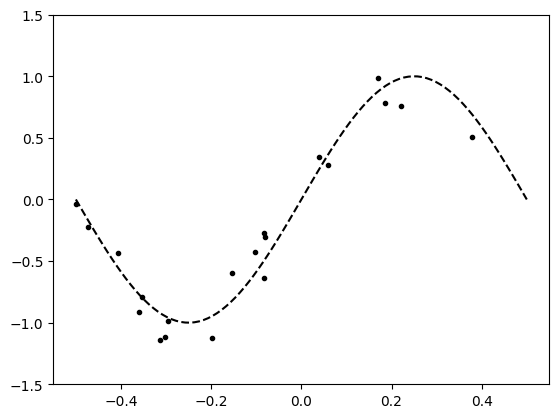

In [27]:
from statsmodels.api import OLS # Para selección de hipótesis
import ModeloLineal as ml       # Para evaluación de hipótesis y modelos (archivo ModeloLineal.py)
from scipy.stats import norm    # La distribución gaussiana
import pandas as pd 

np.random.seed(1) # Para reproducir los datos

N = 20 # Cantidad de datos
D = 10 # Cantidad de modelos (de 0 al 9)
cmap = plt.get_cmap("tab10") # Colores para los modelos

BETA = (1/0.04) # Precisión de los datos, el inverso de su varianza 
ALPHA = (10e-6) # Precisión de la creencia a prior, el inverso de su varianza

# Realidad causal subyacente
def realidad_causal_subyacente(X, beta =  BETA):
    return np.sin(2 * np.pi * X) + np.random.normal(0,np.sqrt(1/beta),X.shape)

def modelo_causal_deterministico(X, H):
    pred = H[d]*X**0
    for j in range(1,i+1):
        pred += H["X"+str(j)]*X_grilla[:,0]**j
    return pred

def modelo_causal_deterministico(X, H):
    y = H[0]*X**0
    for d in range(1,len(H)):
        y += H[d]*X**d
    return y

# Data 
X = np.random.rand(N,1)-0.5
Y = realidad_causal_subyacente(X)
# Grilla
X_grilla = np.linspace(0, 1, 100).reshape(-1, 1)-0.5
Y_grilla = realidad_causal_subyacente(X_grilla, np.inf)

# Figura de 
# la función objetivo
plt.plot(X_grilla, realidad_causal_subyacente(X_grilla, beta=np.inf), '--', color="black")
# y los datos
plt.plot(X,Y,'.', color='black')
plt.ylim(-1.5,1.5)

Quisiéramos actualizar nuestra creencia respecto de las hipótesis $h$ al interior de cada modelo y actualizar nuestra creencia sobre los modelos causales altenativos. Ninguno de estas dos objetivos se pudo realizar de forma exacta hasta las vísperas del siglo $21$. Debido a la complejidad computacional de la aplicación estricta de las reglas de la probabilidad, durante el siglo $20$ se propusieron una gran cantidad de criterios arbitrarios para la selección de una única hipótesis del espacio, como es el principio de máxima verosimilitud.

$$\underset{h}{\text{arg max \ }} p( \bm{y}| \bm{x}, \bm{h}, M_D ) \overset{*}{=}  \underset{h}{\text{arg min \ }} \sum_{i\in \{1,\dots,N\}} (y_i - \sum_d h_d \cdot x_i^d)^2 $$

Por propiedades de este tipo de modelos, encontrar las hipótesis que mejor predicen es lo mismo ($\overset{*}{=}$) que minimizar la suma de las distancias cuadradas entre el verdadero valor y el valor medio propuesto. Seleccionar hipótesis, en vez de evaluarlas, produce una serie de efectos secundarios que se conocen en el área de inteligencia artificial con el nombre de sobreajuste o *overfitting*.  

En este ejemplo nos interesa comparar ver algunos de los efectos secundarios de los métodos propuestos durante el siglo $20$ para comporarlo luego con el resultado de evaluar las hipótesis y modelos mediante la aplicación estricta de las reglas de la probabilidad. En el primer caso usaremos el método OLS (por *Ordinary Least Squares*) del paquete `statsmodels` y para el segundo caso usaremos nuestra propia implementación disponible en el archivo `ModeloLineal.py` (que ya fueron cargados en el código anterior).

### Ejercicio 1.2.1. Seleccionar hipótesis por máxima versosimilitud.

En el siguiente código mostramos cómo seleccionar hipótesis usando el método OLS del paquete statsmodels. Y graficamos el valor de máxima verosimilitud que se obtiene con cada uno de los modelos. Para que el siguiente código funcione solo tienen que completar qué es lo que quieren graficar.

In [ ]:
# COMPLETAR

# Las transformaciones de X que hace el modelo Md de complejidad d
def phi(X, complejidad = D):
    return(pd.DataFrame({f'X{d}': X[:, 0]**d for d in range(complejidad+1)}))

# Itero por modelos Md
modelos_OLS = []
for d in range(0,D):
    # Ajusto el modelo de compeljidad d
    modelos_OLS.append(OLS(Y, phi(X,d)).fit())
    
# Figuras de máxima verosimiliitud
for d in range(10):
    log_maxima_verosimilitud_d = modelos_OLS[d].llf
    plt.bar(d, np.exp( ??? ), align='center', color=cmap(d), label=f'Modelo {d}')

plt.xlabel("Modelos")
plt.ylabel("Máxima verosimilitud")

Efectivamente, podemos ver que a medida que los modelos tienen mayor complejidad aumenta continuamente el valor de máxima verosimilitud, pues al tener mayor fexibilidad pueden acercarse cada vez más a todos los puntos. Esta fexibilidad, al mismo tiempo hace los modelos más complejos adopten formas extrañas que suelen alejarse más de la función objetivo oculta. Esto se puede ver en la siguiente figura.

Para que el siguiente código funcione solo tienen que completar la predicción que hace cada uno de los modelos en todo el rango de posibles valores de $x$. Esto se realiza mediante la función  `modelo_causal_deterministico()`, definida en el primer bloque de código del ejemplo actual 1.2.  

In [ ]:
# Figura de los ajustes.
plt.plot(X_grilla, Y_grilla, '--', color="black")
plt.plot(X,Y,'.', color='black')
plt.ylim(-1.5,1.5)
for d in range(D):
    H = modelos_OLS[d].params # Las hipótesis seleccionadas en el modelo de grado d
    plt.plot(X_grilla, 
             modelo_causal_deterministico( ???? ), 
             color=cmap(d), label= f'Modelo {d}' )

plt.legend(ncol=2)

Los modelos más simples ($0$, $1$ y $2$) y los modelos más compelejos ($8$ y $9$) son los que más se alejan de la sinoidal que queremos ajustar. Esto hace que cuando reciaban nuevos datos suelan tener predicciones malas. Evaluemos esto en el siguiente ejercicio.

### **Ejercicio 1.2.2**: Evaluación de la predicción "en línea" que hacen los modelos ajustados por OLS

Para evaluar correctamete los modelos alternativos deberíamos calcular la evidencia de los modelos, que no es más que la predicción *a priori* que hace el modelo de los datos.

$$P(\text{Datos} = \{ d_1, d_2, \dots\}|M_D) = P(d_1|M_d)P(d_2|d_1,M_D) \dots$$

Es decir, lo que queremos es el producto de las predicciones del siguiente dato usando los datos observados ya vistos como información previa. Para ello, vamos a implementar un procedimeinto en el cual volveremos a ajustar los modelos mediante OLS luego de observar un nuevo dato. Si tuvieramos una distribución de creencias sobre las hipótesis al interior de cada modelo, esa predicción se haría con la contribución de todas las hipótesis. Sin embargo, cuando seleccionamos de forma arbitraria una única hipótesis, esas predicciones las hacemos solo con la hipótesis seleccionada previamente.

$$
\begin{align*}
P(y_i| \underbrace{x_1, y_1}_{d_1}, \dots, \underbrace{x_{i-1}, y_{i-1}}_{d_{i-1}}, x_i, M_D) &= \int_{\bm{h}} P(y_i| d_1, \dots, d_{i-1}, x_i, \bm{h}, M_D) P(\bm{h}|d_1, \dots, d_{i-1}, M_D) \\
& \approx P(y_i| d_1, \dots, d_{i-1}, x_i, \underbrace{\underset{\bm{h}}{\text{ arg max }} P(d_1,  \dots, d_{i-1}| \bm{h}, M_D)}_{\text{Hipóteis de máxima verosimilitud}} , M_D) = \widehat{P}(y_i| d_1, \dots, d_{i-1}, x_i, M_D)
\end{align*}
$$

Es decir, aproximamos las predicciones que deberían hacer los modelos con la contribcuión de todas las hipótesis mediante la predicción que obtenemos con la hipótesis que maximizaba la verosimilitud en el paso anterior, ($\widehat{P}(y_i| d_1, \dots, d_{i-1}, x_i, M_D)$). Esta forma de aproximar la predicción es la que más se parece a lo que nos ocurriría efectivamente si usáramos el modelo en la vida real: ajustamos el modelo con los datos que ya tenemos disponibles (entrenamiento) y evaluamos el desempeño en los datos nuevos (testeo). 

En el siguiente código deben evaluar los modelos alternativos ajustados por OLS mediante el producto de las predicciones *a priori*, entrenadas solo con los datos previos.  

In [ ]:
# Predicción 
def prediccion(y,x,H):
    # P(y|x,h,M)
    py_xhM = norm(loc=modelo_causal_deterministico(x, H), scale=np.sqrt(1/BETA))
    return py_xhM.pdf(y)[0] 

# Inicializa la lista de las evidencias OLS
log_evidencia_OLS = [0 for _ in range(D)]
# Ajusta los modelos con al menos un dato (todos predicen igual el primer dato)
modelos_OLS = [OLS(Y[0:1], phi(X[0:1],d)).fit() for d in range(D)]
# Itera sobre los datos
for i in range(1,N):
    x = X[i]; y = Y[i] # Siguiente dato observado
    # Itera sobre los modelos
    for d in range(D):
        # Hipótesis de máxima verosimilitud
        H = ?????????????????????????????
        # Calcula la predicción en órdenes de magnitud
        log_evidencia_OLS[d] = ??????????????????????????????
        # Vuelve a ajustar el modelo con el nuevo dato
        modelos_OLS[d] = ????????????????????????????? 

# Figura de las evidencias_OLS
for d in range(D):
    plt.bar(d, np.exp(log_evidencia_OLS[d]), align='center', color=cmap(d), label=f'Modelo {d}')

Es interesante que al evaluar el desempeño predictivo que obtenemos en los hechos al usar "en línea" el método OLS de selección arbitrario de hipótesis, encontramos que el modelo con mayor desempeño es el que tiene la menor complejidad necesaria para ajustar el función objetivo. Justamente, un polinomio de grado de 3 tiene la capacidad de subir, bajar y subir nuevamente, como ocurre con un período de la función $\text{sin}()$. Los modelos más simples, de grado 0 a 2, no tienen la flexibilidad necesaria para aproximar un período de la función $\text{sin}()$. Los modelos más complejos, de grado 4 a 9, tienen mayor flexibilidad de la necesaria, lo que les permite proponer estructuras muy distintas a la función objetivo, haciendo que en los hecho tengan menor desempeño que el modelo de grado 3. 

La diferencia de desempeño es tan grande que si actualizáramos la creencia respecto de los modelos alternativos, rechazaríamos tanto los modelos de menor compeljidad (grado 0 a 2) como los de mayor compeljidad (grado 4 a 9). Esto hace que la predicción de los futuros datos se haga exclusivamente con la contribución de un único modelo.

$$
\begin{align*}
P(\text{Datos}) &= \sum_{d} P(\text{Datos}|\text{Modelo}=d) P(\text{Modelo}=d) \overset{*}{=} P(\text{Datos}|\text{Modelo} = 3) 
\end{align*}
$$

Al rechazar los modelos más complejos, la predicción de nuevos datos se reduce ($\overset{*}{=}$) a la predicción que hace el modelo 3. Esto es un efecto secundario negativo de la ruptura de las reglas de la probabilidad, porque si en el futuro recibiéramos datos por fuera del período observado, no podríamos predecirlo correctamente dado que el modelo de grado 3 tendrá menor flexibilidad de la necesaria para predecirlo.

La introducción de criterios arbitrarios en el sistema de razonamiento probabilístico produce siempre efectos secundarios no deseados, que deben ser corregidos añadiendo otros criterios arbitrarios. Ninguno de estos atajos ha mostrado hasta ahora la capacidad para alcanzar el funcionamiento óptimo de la aplicación estricta de las reglas de la probabilidad.

### **Ejercicio 1.2.3**. Más criterios arbitrarios de selección de hipótesis: los regularizadores

Una familia de criterios arbitrarios de selección de hipótesis muy difundida son los llamados regularizadores. En vez de seleccionar la hipótesis que mejor predice los datos (máxima verosimilitud) elegimos, por ejemplo, la hipótesis que tienen mayor creencia luego de observar los datos (máximo a posteriori).

$$
\begin{align*}
\underset{h}{\text{arg max \ }} \underbrace{p(\bm{h}| \overbrace{\bm{y}, \bm{x}}^{\text{Datos}}, M_D )}_{\text{Posterior}} = & 
\underset{h}{\text{arg max \ }} \overbrace{p( \bm{y}| \bm{x}, \bm{h}, M_D )}^{\text{Verosimilitud}} \overbrace{p(\bm{h}|M_D )}^{\text{Prior}} \\
\overset{*}{=}& \underset{h}{\text{arg min \ }} \underbrace{\sum_{i} (y_i - \sum_d h_d \cdot x_i^d) ^2}_{\text{Distancia entre dato y predicción media}} + \underbrace{ \frac{\alpha}{2}||h||^2}_{\text{Penalización}}
\end{align*}
$$

Por propidades del modelo, maximizar el producto de la verosimilitud con el prior es equivalente ($\overset{*}{=}$) a minimizar la suma de distancias cuadradas entre el dato y la predicción, más la suma de la distancia cuadrada de las hipótesis al origen pesada por la precisión a priori sobre las hipótesis $\alpha$. Esto hace que la hipótesis que se seleccione no sea la que más se acerca a los datos, sino la que mejor balance tenga entre la distancia y la penalización.

Veamos cómo se desempeñan los modelos bajo este nuevo criterio arbitrario de selección de hipótesis. Vamos a proceder del modo similar a lo realizado en los ejercicios 1.2.1 y 1.2.2. Para calcular el posterior exacto sobre las hipótesis vamos a usar nuestra propia implementación disponible en el archivo `ModeloLineal.py`. Debido a que la penalización depende del prior, vamos a calcular el posterior usando un prior 100 veces más informativo que el prior que definimos al inicio del ejemplo 1.2.

In [ ]:
import ModeloLineal as ml  # Vamos a usar nuestra propia implemetación, que tiene la solución exacta 

# Para guardar las hipótesis seleccionadas por Maximo a Posteriori (MAP) 
modelos_MAP = []
# Itrera sobre los modelos
for d in range(D):
    # Calcula el posterior exacto con nuestra propia implemetación
    MU_d, COV_d = ml.posterior(Y,phi(X, complejidad = d)
                               , alpha=ALPHA*100) # Un prior 100 veces más informativo que el valor por defecto
    # Guarda el valor medio (MAP) y la covarianza entre hipótesis.
    modelos_MAP.append({"mean":MU_d.reshape(1,d+1)[0], # Las hipótesis que maximizan el posterior
                        "cov":COV_d})                  # Guardamos la covarianza del posterior (gaussiana multivariada)

# Figura de los ajustes.
plt.plot(X_grilla, Y_grilla, '--', color="black")
plt.plot(X,Y,'.', color='black')
plt.ylim(-1.5,1.5)
for d in range(D):
    plt.plot(X_grilla,
             modelo_causal_deterministico(??????, ????????),
             color=cmap(d), label= f'Modelo {d}' )

plt.legend(ncol=2)

Los modelos que se ven más afectados por el regularizador son los modelos más complejos. Se puede ver que la selección de hipótesis por máximo a posteriori hace que los modelos más complejos tengan un comportamiento casi idéntido a los modelos de menor complejidad como el del grado 3. De hecho, si comparamos los valores de las hipótesis seleccionadas en el modelo de grado 9 mediante OLS y MAP vamos a ver que las hipótesis de mayor grado se "apagan", haciendo que el modelo funcione en los hechos como un modelo más simple.

In [36]:
print("OLS: ", list(np.abs(modelos_OLS[9].params)))
print("MAP: ", list(np.abs(modelos_MAP[9]["mean"])))

OLS:  [0.02456666901377158, 5.334919032471657, 10.346157679497011, 24.948552065890794, 442.371495227148, 1527.613704736319, 3428.184462574747, 11118.751168827097, 6128.6052633875515, 20627.50771908532]
MAP:  [0.04661045588373021, 5.486991648236886, 1.574034374924085, 27.57898263783073, 1.9771496287728827, 8.243475767032663, 7.2810188160599125, 6.178082341382847, 3.7276874268786218, 2.3375049885211405]


Esto hace que los modelos más complejos tengan mejor desempeño, incluso mejor que el modelo simple. En el siguiente código veremos de hecho, que el desempeño predictivo de los modelos más complejos termina siendo mayor que la de todo el resto.  

In [ ]:
# Proceder de forma similar al ejercicio 1.2.2 

# Seleccionar las hipótesis con el primer dato Y[0:1] e X[0:1]
modelos_MAP = []
for d in range(D):
    MU_d, COV_d = ?????            # Usar el método posterior del paquete ModeloLineal (as ml)
    modelos_MAP.append(?????)      # Guardar los datos como en el ejercicio 1.2.2. 

# Inicializa el órden de magnitud de las evidencias en 0
log_evidencia_MAP = [0 for _ in range(D)]
# Itera sobre los datos
for i in range(1,N):
    x = X[i]; y = Y[i] # Siguiente dato observado
    # Itera sobre los modelos
    for d in range(D):
        # Hipótesis de máxima verosimilitud
        H = ??????????????????????
        log_evidencia_MAP[d] = ????????????????????
        MU_d, COV_d =  ????????????????????
        modelos_MAP[d] =  ????????????????????

# Figura
for d in range(D):
    plt.bar(d, np.exp(log_evidencia_MAP[d]), align='center', color=cmap(d), label=f'Modelo {d}')


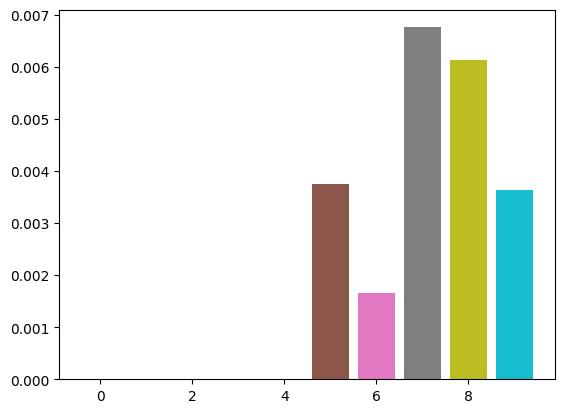

In [37]:
# Selecciona las hipótesis con el primer dato Y[0:1] e X[0:1]
modelos_MAP = []
for d in range(D):
    MU_d, COV_d = ml.posterior(Y[0:1],phi(X[0:1], complejidad = d), alpha=ALPHA*100)
    modelos_MAP.append({"mean":MU_d.reshape(1,d+1)[0], "cov":COV_d})

# Inicializa el órden de magnitud de las evidencias en 0
log_evidencia_MAP = [0 for _ in range(D)]
# Itera sobre los datos
for i in range(1,N):
    x = X[i]; y = Y[i] # Siguiente dato observado
    # Itera sobre los modelos
    for d in range(D):
        # Hipótesis de máxima verosimilitud
        H = modelos_MAP[d]["mean"]
        log_evidencia_MAP[d] += np.log(prediccion(y,x,H))
        MU_d, COV_d = ml.posterior(Y[0:d],phi(X[0:d], complejidad = d), alpha=ALPHA*100)
        modelos_MAP[d] = {"mean":MU_d.reshape(1,d+1)[0], "cov":COV_d}


for d in range(D):
    plt.bar(d, np.exp(log_evidencia_MAP[d]), align='center', color=cmap(d), label=f'Modelo {d}')


En este caso estamos rechazando todos los modelos simples, quedándonos con los modelos de mayor compeljidad. Si bien esto podría parecer una solución al problema del ejercicio 1.2.2, no lo es. Así como el rechazo de todos los modelos salvo el de grado 3 hacía que no pudieramos predecir potenciales datos futuros que estuvieran fuera del período observado, la selección de los modelos más complejos no ocurre por mérito de su complejidad sino porque la reducción de flexibilidad que le impusimos mediante la regularización. En términos prácticos, los modelos complejos están funcionando commo una variante apenas más flexible que el modelo 3 regularizado. La regularización de hipótesis entonces no resuelve el problema, pues cuando veamos datos por fuera del período observado, estos modelos tampoco van a ser capaces de predecir los nuevos datos.

$$
\begin{align*}
P(\text{Datos}) &= \sum_{d \in \{5, \dots, 9\}} P(\text{Datos}|\text{Modelo}=d) P(\text{Modelo}=d) \approx P(\text{Datos}|\text{Modelo} = 3) 
\end{align*}
$$



### **Ejercicio 1.2.4**: El balance natural de las reglas de la probabilidad.

Para evaluar correctamente las hipótesis y modelos causales alternativos es suficiente con actualizar las creencias aplicando estrictamente las reglas de la probabilidad. Para eso necesitamos calcular la probabilidad a posteriori de los los modelos dado los datos.

$$P(\text{Modelo} = d|\text{Datos})  =  \frac{\overbrace{P(\text{Datos}|\text{Modelo} = d)}^{\text{Evidencia}} P(\text{Modelo}=d)}{\sum_i P(\text{Datos}|\text{Modelo} = i) P(\text{Modelo}=i])}$$

En el siguiente código vamos a usar el método `lm.log_evidence()` de nuestro paquete `ModeloLineal.py` para calcular de forma éxacta la evidencia del modelo en órdenes de magnitud. Y suponiendo que no tenemos preferencia a priori por ningún modelo, vamos a usar la evidencia para calcular el posterior exacto de los modelos.    

In [ ]:
# La evidencia P(Datos|Modelo) en escala logarítmica
log_evidence_d = []
for d in range(D):
    log_evidence_d.append(ml.log_evidence(Y, phi(X,d))[0][0])

# El posterior P(Modelo | Datos) 
pM_Datos = ???????????????????????????????????????

# Figura del posterior
for d in range(D):
    plt.bar(d, pM_Datos[d], align='center', color=cmap(d), label=f'Modelo {d}')

Cuando evaluamos correctamente las hipótesis, encontramos que: el modelo que tiene la menor complejidad necesaria (grado 3) es el que obtiene mayor creencia a posteriori; los modelos que tienen menor complejidad de la necesaria (grado 0 a 2) son rechazados; y los modelos que tienen mayor complejidad de la necesaria (grado 4 a 9) tienen baja probabuilidad, pero no son rechazados. A diferencia de lo que ocurría cuando seleccionábamos hipótesis de forma arbitraria, evaluando correctamente las hipótesis garantizamos nuestra capacidad para predecir potenciales datos que aparecieran en el futuro por fuera del del período observado gracias a que tenemos disponibles todavía modelos más complejos capaces de explicarlos. 

$$P(\text{Datos}) = \sum_d P(\text{Datos}|\text{Modelo} = d)  P(\text{Modelo} = d) $$

En definitva, los problemas que emergen cuando se seleccionan las hipótesis mediante criterios arbitrarios simplemente no forman parte del sistema de razonamiento en contextos de incertidumbre. Por eso, la aplicación estricta de las reglas de la probabilidad, siguiendo el principio de "no mentir", garantiza siempre un razonamiento correcto en contextos de incertidumbre. 

### Ejercicio 1.2.5: Cómo se explica el balance natural de las reglas de la probabilidad

En probabilidad las predicciones son distribuciones de probabilidad que deben integrar 1. Esto produce una balance natural entre los modelos, pues ningún modelo es superior a otro en términos absolutos. Todos tienen una región en donde ganan y todos tienen una región donde pierden. Veamos esto de forma concreta. 

En el siguiente código vamos a graficar la media del posterior de los modelos. La incertidumbre de los modelos, que no estamos gráfcando, representa la predicción que hacen los modelos de los datos. Para graficar esa incertidumbre vamos a hacer un corte en cuando $x$ vale $-0.23$ (linea vertical). 

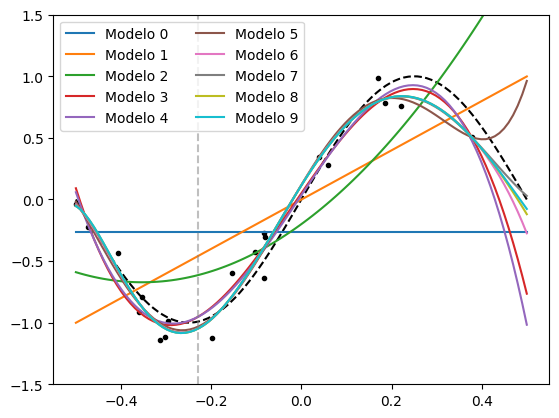

In [33]:
modelos_MAP = []
for d in range(D):
    MU_d, COV_d = ml.posterior(Y,phi(X, complejidad = d), alpha=ALPHA)
    modelos_MAP.append({"mean":MU_d.reshape(1,d+1)[0], "cov":COV_d})

plt.plot(X_grilla, Y_grilla, '--', color="black")
plt.plot(X,Y,'.', color='black')
plt.ylim(-1.5,1.5)
for d in range(D):
    plt.plot(X_grilla,
             modelo_causal_deterministico(X_grilla, modelos_MAP[d]["mean"]),
             color=cmap(d), label= f'Modelo {d}' )

plt.axvline(-0.23, linestyle="--", color = "gray", alpha=0.5)
plt.legend(ncol=2)


Si hacemos un corte en línea punteada ($x=-0.23$) y graficamos la predicción que hace el modelo más rígido (grado 0), el modelo simple (grado 3) y el modelo más complejo (grado 9) luego de ver el cuarto dato, vamos a observar tres distribuciones gaussianas con diferente media y diferente desvío estandar.

In [ ]:
# La posición donde veremos el siguiente dato y_new
x_new = np.array([[-0.23]])
# Todos los posibles valores del siguiente dato (en un rango)
y_range = np.arange(-2.5,0.5,0.01).reshape(1,300)

# P(y|x_new, Datos, Modelo) 
py_xnewDatosMd = []
for d in range(D):
    pred = ml.predictive(y_range,                                  # y (todo el rango)
                         np.matrix(phi(x_new,d)),                  # x_new = -0.23 (su transformación)
                         alpha=ALPHA, beta=BETA,                   # Priors (modelo)
                         t_priori= Y[0:4],                         # Datos_y los primeros 4
                         Phi_priori = np.matrix(phi(X[0:4],d)))    # Datos_x los primeros 4 (su transformación)
    py_xnewDatosMd.append(pred)

# Figuras de P(y|x_new, Datos, Modelo = d ) con d in [0,3,9]
plt.plot(y_range[0,:], ????? , color=cmap(0), label = "Rígido (grado 0)")
plt.plot(y_range[0,:], ????? , color=cmap(3), label = "Simple (grado 3)")
plt.plot(y_range[0,:], ????? , color=cmap(9), label = "Complejo (grado 9)")
plt.xlabel("y|x=-0.23")
plt.ylabel("P(Datos | Modelo)")
plt.legend()

El modelo más rígidos (grado 0) concentra su creencia en una región lejana al valor verdadero. Los modelos simples (grado 3) y complejo (grado 9) distribuyen su creencia alrededor del verdadero valor. Además, cuanto mayor flelxibilidad tienen los modelos, mayor tendencia a distribuir la creencia en una región más amplia de valores posibles. El modelo rígido se rechaza por su incapacidad de llevar su creencia a la región correcta. Pero entre el modelo simple y el modelo complejo hay una balance en el cual existen ciertas regiones donde el modelo simple gana y ciertas regiones donde el modelo más complejo gana. En términos un poco más esquemáticos (con $x = 0.1$) lo que ocurre es.

<center>
<img src="https://raw.githubusercontent.com/BayesDeLasProvinciasUnidasDelSur/static/master/curso/2024/evidencia_de_modelos_alternativos.png" alt="drawing" width="50%"/>
</center>


## **Ejemplo 1.3**: Efecto causal del sexo biológico sobre la altura.

Vamos a utilizar un conjunto de datos sobre alturas de un grupo de personas y 3 variables adicionales: sexo biológico, contextura de la madre, y altura de la madre. En este ejemplo vamos a proponer modelos causales alternativos entre estas variables. Visualicemos los datos

In [40]:
import pandas as pd 
Alturas = pd.read_csv("datos/alturas.csv")
Alturas.head()

,id,altura,sexo,contextura_madre,altura_madre
0,1,172.7,M,mediana,159.8
1,2,171.5,M,mediana,160.3
2,3,162.6,F,mediana,160.5
3,4,174.1,M,mediana,159.8
4,5,168.3,M,mediana,158.3


Si bien los datos son de dudodsa procedencia, vamos a jugar un juego de inferencia causal. Vamos a proponer y evaluar tres modelos causales alternativos. En el modelo base vamos a suponer que la altura de la madre tienen un efecto causal lineal sobre la altura de su descendencia. 

$$\text{Modelo Base: \ }\texttt{altura} = h_0 + h_1 \cdot \texttt{altura\_madre} $$

En el modelo biológico vamos a suponer que el sexo tiene un efecto causal adicional sobre la altura.

$$\text{Modelo Biológico: \ }\texttt{altura} = h_0 + h_1 \cdot \texttt{altura\_madre} + h_2 \cdot \mathbb{I}(\texttt{sexo} = F)$$

Cuando el sexo es masculino, la función identidad $\mathbb{I}(\texttt{sexo} = M)$ vale 1 y en caso contrario vale 0, lo que prende y apaga la hipótesis $h_2$, que reprersentar el efecto causal adicional del sexo biológico.

Por último vamos a plantear el modelo identitario, en el que vamos a suponer que la identidad de la persona (y no el sexo) tiene efecto causal sobre la altura. 

$$\text{Modelo Identitario: \ }\texttt{altura} = h_0 + h_1 \cdot \texttt{altura\_madre} +  h_{2+(\texttt{ID mod max(ID)/2})} $$


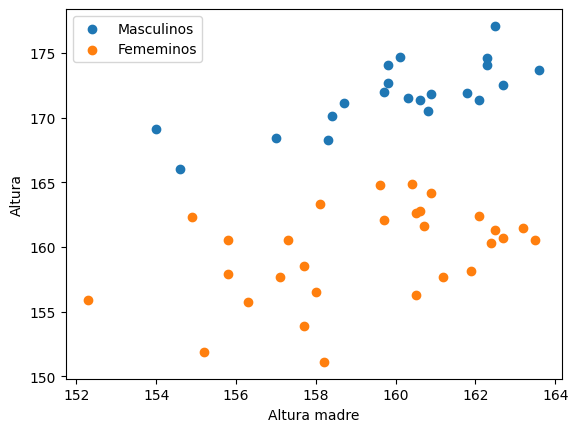

In [41]:
plt.scatter(Alturas.altura_madre[Alturas.sexo=="M"],Alturas.altura[Alturas.sexo=="M"], label="Masculinos")
plt.scatter(Alturas.altura_madre[Alturas.sexo=="F"],Alturas.altura[Alturas.sexo=="F"], label="Fememinos")
plt.xlabel("Altura madre")
plt.ylabel("Altura")
plt.legend()

In [ ]:
import ModeloLineal as lm

N, _ = Alturas.shape
Y_alturas = Alturas.altura
X_base = pd.DataFrame({"Base": [1 for _ in range(N)],    # Origen
                       "Altura": Alturas.altura_madre,  # Pendiente
             })
X_biologico = pd.DataFrame({"Base": [1 for _ in range(N)],    # Origen
                            "Altura": Alturas.altura_madre,  # Pendiente
                            "Sexo": (Alturas.sexo=="M")+0     # Sexo
             })
X_identidad = {"Base": [1 for _ in range(N)],    # Origen
               "Altura": Alturas.altura_madre  # Pendiente
            }
for i in range(25):
    X_identidad[f'id{i}'] = [ ((j % 25) == i)+0 for j in range(N)]

X_identidad = pd.DataFrame(X_identidad)

log_pDatos_Modelo = np.zeros(3)
log_pDatos_Modelo[0] = (ml.log_evidence(Y_alturas, X_base))
log_pDatos_Modelo[1] = (ml.log_evidence(Y_alturas, X_biologico))
log_pDatos_Modelo[2] = (ml.log_evidence(Y_alturas, X_identidad))

(ml.posterior(Y_alturas, X_base))
(ml.posterior(Y_alturas, X_biologico))
(ml.posterior(Y_alturas, X_identidad))

print(log_pDatos_Modelo)


(array([ 3.4972112 ,  1.00947024, -2.10297823, -1.16955149, -1.35581957,
         3.7842354 ,  0.30933237,  0.69749458, -0.81481659, -0.97570711,
         0.07760719, -0.80610099, -4.1548721 ,  1.63470951, -0.40771396,
         5.90961263, -0.98375681, -1.1482437 , -4.26481568, -7.66197402,
         8.77211536, -5.54256061, -0.16244908,  1.66387491, -1.50439909,
         8.01264539,  5.69133778]),
 array([[ 3.85126234e+03, -3.32957296e-02, -3.84596755e+03,
         -3.84590928e+03, -3.84595756e+03, -3.84592260e+03,
         -3.84601084e+03, -3.84596922e+03, -3.84592593e+03,
         -3.84588764e+03, -3.84589930e+03, -3.84613237e+03,
         -3.84596089e+03, -3.84592427e+03, -3.84595090e+03,
         -3.84583603e+03, -3.84585934e+03, -3.84598420e+03,
         -3.84592593e+03, -3.84593592e+03, -3.84605578e+03,
         -3.84600418e+03, -3.84593426e+03, -3.84585102e+03,
         -3.84596256e+03, -3.84602249e+03, -3.84594757e+03],
        [-3.32957296e-02,  2.17043532e-04, -1.21419163e-03